## Multi-label ATM chat support classification using TF-IDF and Word2vec
#### Author: Sokolov Alexander
Jupyter Notebook created as a test task for Multicarta

16.10.2021

## Contents:
* [Pre-work](#pre)
* [Data Load](#data)
* [Exploratory Data Analysis](#eda)
* [Использование Tf-idf](#tf)
* [Построение классификатора NB](#nb)
* [Результаты NB алгоритма](#nb)
* [Использование ruBERT deeppavlov](#rubert)
* [Построение логистической регрессии на эмбеддингах ruBERT](#log)



# Pre-work <a class="anchor" id="pre"></a>

Для начала загрузим все необходимые библиотеки

In [1]:
## for data
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
## for explainer
from lime import lime_text
## for word embedding
import gensim
import gensim.downloader as gensim_api
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
## for bert language model
import transformers
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.feature_selection import SelectFromModel

In [3]:
import pandas as pd
import numpy as np

# Data-load <a class="anchor" id="data"></a>

In [4]:
df = pd.read_excel('ceo_train_v2.14-19032021.xlsx')

In [5]:
df.head()

,Номер инцидента СКТО,ATM,Регион,Город,Дата обращения,id Категории обращения,Категория обращения,Комментарий,target,sub_target
0,217914718.0,396520,Самара,Саратов,2019-04-29 10:07:00,99,Прочее,со слов клиента- банкомат не однократно осущес...,cards,cards
1,NaN,383782,Санкт-Петербург,Архангельск,2019-01-14 11:48:00,99,Прочее,добрый день!просьба удаленно перезагрузить ус....,"remote_reboot,cassette","remote_reboot,cassette"
2,NaN,394943,Новосибирск,Железнодорожный,2019-04-12 07:17:00,99,Прочее,нет операций,no_oper,no_oper
3,NaN,389998,Санкт-Петербург,Санкт-Петербург,2019-04-03 19:56:00,99,Прочее,просьба перезагрузить банкомат по питанию удал...,remote_reboot,remote_reboot
4,218571743.0,379196,Москва,Москва,2019-11-19 12:25:00,99,Прочее,проблемы с картридером - захват карт - не возв...,cards,cards


In [6]:
df.shape

(37512, 10)

Приведем слова в  target к числовым категориям

In [7]:
df['category_id'] = df['target'].factorize()[0]

# Exploratory data analysis <a class="anchor" id="eda"></a>

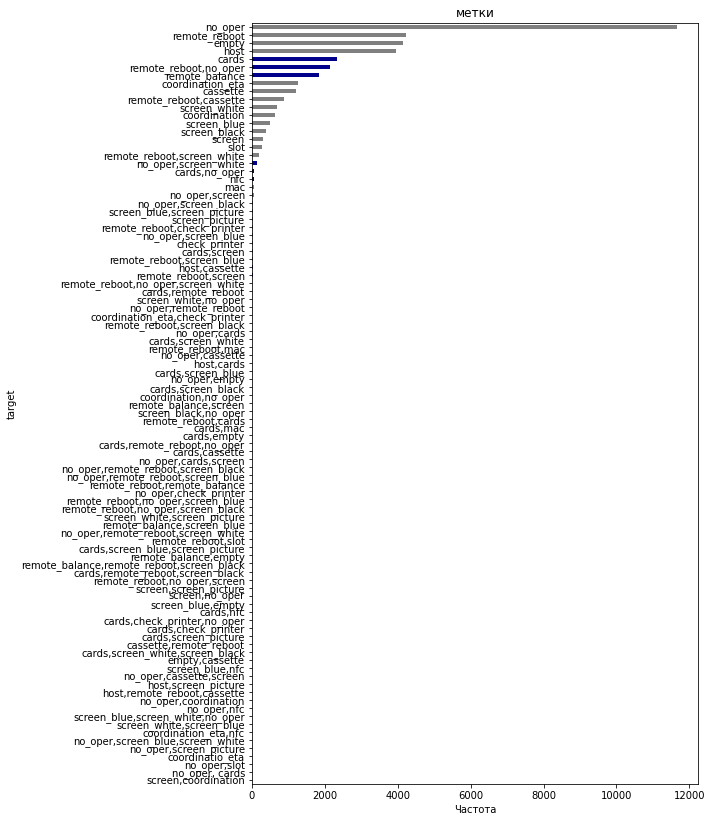

In [8]:
fig = plt.figure(figsize=(8,14))
colors = ['grey','grey','grey','grey','grey','grey','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
df.groupby('target').Комментарий.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'метки')
plt.xlabel('Частота', fontsize = 10);

У нас получилось 95 уникальных меток, сведем их к основным 18 и будем анализировать их

In [9]:
dtf = df[ df['target'].isin(['no_oper','remote_reboot','empty','host','cards','remote_reboot_no_oper',
                             'remote_balance','coordination_eta','cassette','remote_reboot_cassette',
                             'screen_white','coordination','screen_blue','screen_black','screen','slot',
                             'remote_reboot.screen_white','no_oper.screen_white']) ][['target','Комментарий']]

In [10]:
dtf = dtf.rename(columns={'target':'y', 'Комментарий':'text'}) # переименуем колонки для удобного обращения к ним

In [11]:
dtf.sample(5)

,y,text
18771,no_oper,нет операций за 29/05
15668,no_oper,длительное время нет операций
3154,no_oper,нет операций за 01.08
5705,no_oper,нет операций. просьба проверить удаленно.
1759,no_oper,отсутствуют операции


Чтобы понять состав набора данных, построим столбчатую диаграмму, которая показывает частоту меток в только созданных данных

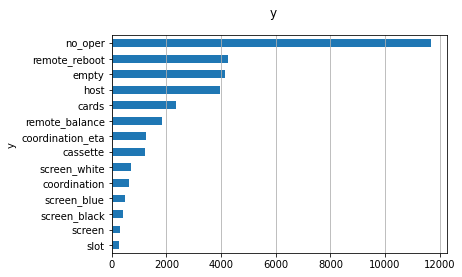

In [12]:
fig, ax = plt.subplots()
fig.suptitle('y', fontsize=12)
dtf['y'].reset_index().groupby('y').count().sort_values(by= 
       'index').plot(kind='barh', legend=False, 
        ax=ax).grid(axis='x')
plt.show()

Набор данных несбалансирован: доля no_oper действительно огромна по сравнению с другими, поэтому моделям будет довольно сложно распознавать заявки, в которых частота ниже 2000.
Перед построением модели,нужно провести предварительную обработку путем очистки текста, удаления стоп-слов и применения лемматизации.х.

In [13]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## Обработаем текст (преобразуем в нижний регистр и удалим знаки препинания и лишние символы)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Токенизируем (Преобразуем из строки в список)
    lst_text = text.split()
    ## Уберем стоп-слова
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Стемминг (уберем окончания)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Лемматизация (преобразуем слова в изначальную форму)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## вернемся к строке из списка
    text =' '.join(lst_text)
    return text

Далее импортурем корпус стоп-слов на русском языке

In [14]:
lst_stopwords = nltk.corpus.stopwords.words('russian')
lst_stopwords

['и',
 'в',
 'во',
 'не',
 'что',
 'он',
 'на',
 'я',
 'с',
 'со',
 'как',
 'а',
 'то',
 'все',
 'она',
 'так',
 'его',
 'но',
 'да',
 'ты',
 'к',
 'у',
 'же',
 'вы',
 'за',
 'бы',
 'по',
 'только',
 'ее',
 'мне',
 'было',
 'вот',
 'от',
 'меня',
 'еще',
 'нет',
 'о',
 'из',
 'ему',
 'теперь',
 'когда',
 'даже',
 'ну',
 'вдруг',
 'ли',
 'если',
 'уже',
 'или',
 'ни',
 'быть',
 'был',
 'него',
 'до',
 'вас',
 'нибудь',
 'опять',
 'уж',
 'вам',
 'ведь',
 'там',
 'потом',
 'себя',
 'ничего',
 'ей',
 'может',
 'они',
 'тут',
 'где',
 'есть',
 'надо',
 'ней',
 'для',
 'мы',
 'тебя',
 'их',
 'чем',
 'была',
 'сам',
 'чтоб',
 'без',
 'будто',
 'чего',
 'раз',
 'тоже',
 'себе',
 'под',
 'будет',
 'ж',
 'тогда',
 'кто',
 'этот',
 'того',
 'потому',
 'этого',
 'какой',
 'совсем',
 'ним',
 'здесь',
 'этом',
 'один',
 'почти',
 'мой',
 'тем',
 'чтобы',
 'нее',
 'сейчас',
 'были',
 'куда',
 'зачем',
 'всех',
 'никогда',
 'можно',
 'при',
 'наконец',
 'два',
 'об',
 'другой',
 'хоть',
 'после',
 'на

In [15]:
lst_stopwords.remove('нет') 

Теперь создадим новую колонку с предобработанным текстом. Сразу вижу, что минус в том, что во 2 строке вместо нет операций остается текст просто операций, что меняет семантику предложения.

In [16]:
dtf['text_clean'] = dtf['text'].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
dtf.head()

,y,text,text_clean
0,cards,со слов клиента- банкомат не однократно осущес...,слов клиента банкомат однократно осуществляет ...
2,no_oper,нет операций,нет операций
3,remote_reboot,просьба перезагрузить банкомат по питанию удал...,просьба перезагрузить банкомат питанию удаленн...
4,cards,проблемы с картридером - захват карт - не возв...,проблемы картридером захват карт возвращает жа...
5,no_oper,отсутствуют операции,отсутствуют операции


После предобработки корпуса, разобьем данные 70/30   на тренировочную и тестовую выборку

In [17]:
## Рассплитим данные на тренировочную и тестовую выборку
dtf_train, dtf_test = model_selection.train_test_split(dtf, test_size=0.3)
## get target
y_train = dtf_train['y'].values
y_test = dtf_test['y'].values

Частота использования терминов не обязательно является лучшим представлением текста. В корпусе можно найти общие слова с самой высокой частотой, но с небольшой предсказательной силой по целевой переменной. 

Для решения этой проблемы существует расширенный вариант пакета слов, в котором вместо простого подсчета используется термин 'частота - обратная частота документа' (Tf – Idf). По сути, значение слова увеличивается пропорционально количеству, но оно обратно пропорционально частоте слова в корпусе.

Начнем с Feature Engineering - процесса создания функций путем извлечения информации из данных. Я собираюсь использовать векторизатор Tf-Idf с ограничением в 10 000 слов, захватывая униграммы и биграммы.

# Tf-idf анализ <a class="anchor" id="tf"></a>

In [18]:
## BoW
vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2))

## Tf-Idf 
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

Теперь воспользуемся векторизатором на предварительно обработанном корпусе тренировочного сета, чтобы извлечь словарь и создать матрицу признаков.

In [19]:
corpus = dtf_train['text_clean']
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

(23411, 10000)


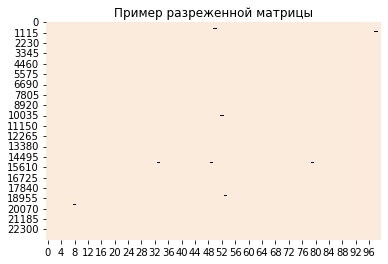

In [20]:
sns.heatmap(X_train.todense()\
            [:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Пример разреженной матрицы')
print(X_train.shape)

Матрица характеристик X_train имеет форму 23 411 (количество обучаемых документов) x 10 000 (длина словарного запаса), и она довольно скудная

Если слово существует в словаре, эта команда печатает число N, означающее, что это слово является N-й характеристикой матрицы.
Чтобы отбросить некоторые столбцы и уменьшить размерность матрицы, мы можем выполнить выбор функций, то есть процесс выбора подмножества соответствующих переменных. Я поступлю следующим образом:
рассматривать каждую категорию как двоичную (например, категория «Технологии» равна 1 для технических новостей и 0 для остальных);
выполнить тест хи-квадрат, чтобы определить, являются ли функция и (двоичная) цель независимыми;
оставить только функции с определенным значением p из теста хи-квадрат.

In [21]:
from sklearn import feature_selection

In [22]:
y = dtf_train['y']
X_names = vectorizer.get_feature_names()
p_value_limit = 0.95
dtf_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {'feature':X_names, 'score':1-p, 'y':cat}))
    dtf_features = dtf_features.sort_values(['y','score'], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features['score']>p_value_limit]
X_names = dtf_features['feature'].unique().tolist()

Я сократил количество функций с 10 000 до 7476, сохранив наиболее статистически значимые.

In [23]:
dtf_features['feature'].nunique()

7468

In [24]:
for cat in np.unique(y):
   print('# {}:'.format(cat)) 
   print('  - Выбранных фич:',
         len(dtf_features[dtf_features['y']==cat]))
   print('  - топ фичи:', ','.join(
dtf_features[dtf_features['y']==cat]['feature'].values[:10]))
   print(' ')

# cards:
  - Выбранных фич: 1478
  - топ фичи: атм захватывает,атм изъял,атм изымает,банкомат захватывает,банкомат изымает,деньбанкомат,деньбанкомат захватывает,диагностику,диагностику кардридера,добрый деньбанкомат
 
# cassette:
  - Выбранных фич: 208
  - топ фичи: видит,видит кассету,кас,кассет,кассета,кассетапрошу,кассетапрошу удаленно,кассету,кассеты,нет
 
# coordination:
  - Выбранных фич: 338
  - топ фичи: атм контакты,время,время подъезда,данные,данные инженера,данные планирования,дату,дату время,дату выезда,дать
 
# coordination_eta:
  - Выбранных фич: 348
  - топ фичи: банкомат готов,банкомат загрузке,банкомата готовности,восстановлена,восстановлена работоспособность,восстановления,восстановления работоспособности,восстановления ус,время восстановления,время окончания
 
# empty:
  - Выбранных фич: 2823
  - топ фичи: атм выдает,атм принимает,банкомат принимает,банкомату,банкомату давно,выгружен просьба,выдает,выдает денежные,выдал,грязный
 
# host:
  - Выбранных фич: 517
  - то

Мы можем переоборудовать векторизатор в корпус, предоставив этот новый набор слов в качестве входных данных. Это приведет к уменьшению матрицы функций и сокращению словарного запаса.

In [25]:
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

(23411, 7468)


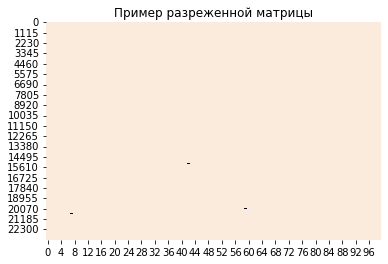

In [26]:
sns.heatmap(X_train.todense()\
            [:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Пример разреженной матрицы')
print(X_train.shape)

# Построение классификатора NB <a class="anchor" id="nb"></a>

Теперь будем обучать модель машинного обучения и тестировать. 
В качестве алгоритма я выбрал Наивный алгоритм Байеса: вероятностный классификатор, использующий теорему Байеса, использующий вероятность для прогнозирования, основанного на предварительном знании условий, которые могут быть связаны. 
Этот алгоритм является наиболее подходящим для такого большого набора данных, поскольку он рассматривает каждую функцию независимо, вычисляет вероятность каждой категории, а затем предсказывает категорию с наибольшей вероятностью.

In [27]:
classifier = naive_bayes.MultinomialNB()

Я собираюсь обучить этот классификатор на матрице признаков, а затем протестировать его на преобразованном наборе тестов. 
Для этого нужно построить конвейер scikit-learn: последовательное применение списка преобразований и окончательной оценки. Включение векторизатора Tf-Idf и наивного байесовского классификатора в конвейер позволит преобразовывать и предсказывать тестовые данные всего за один шаг.

In [28]:
## пайплайн
model = pipeline.Pipeline([('vectorizer', vectorizer),  
                           ('classifier', classifier)])
## тренировочный классификатор
model['classifier'].fit(X_train, y_train)
## тестовый классификатор
X_test = dtf_test['text_clean'].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

# Результаты NB алгоритма <a class="anchor" id="res"></a>

In [29]:
import sklearn.metrics as metrics

Accuracy: 0.91
Auc: 0.99
Detail:
                  precision    recall  f1-score   support

           cards       0.89      0.79      0.84       734
        cassette       0.97      0.99      0.98       356
    coordination       0.94      0.68      0.79       183
coordination_eta       0.87      0.90      0.89       362
           empty       0.67      0.91      0.77      1234
            host       0.99      1.00      1.00      1176
         no_oper       0.95      0.97      0.96      3529
  remote_balance       0.98      0.95      0.97       514
   remote_reboot       0.97      0.96      0.96      1293
          screen       1.00      0.03      0.06        97
    screen_black       1.00      0.32      0.48       126
     screen_blue       1.00      0.33      0.50       145
    screen_white       0.95      0.68      0.80       206
            slot       1.00      0.35      0.52        79

        accuracy                           0.91     10034
       macro avg       0.94      0.71

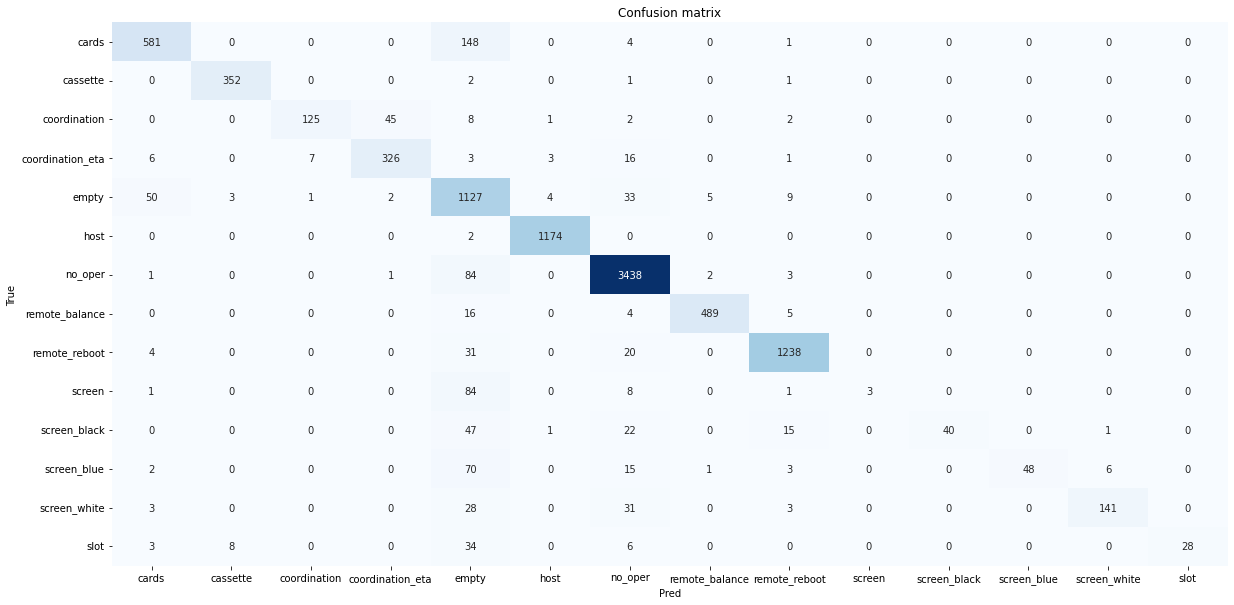

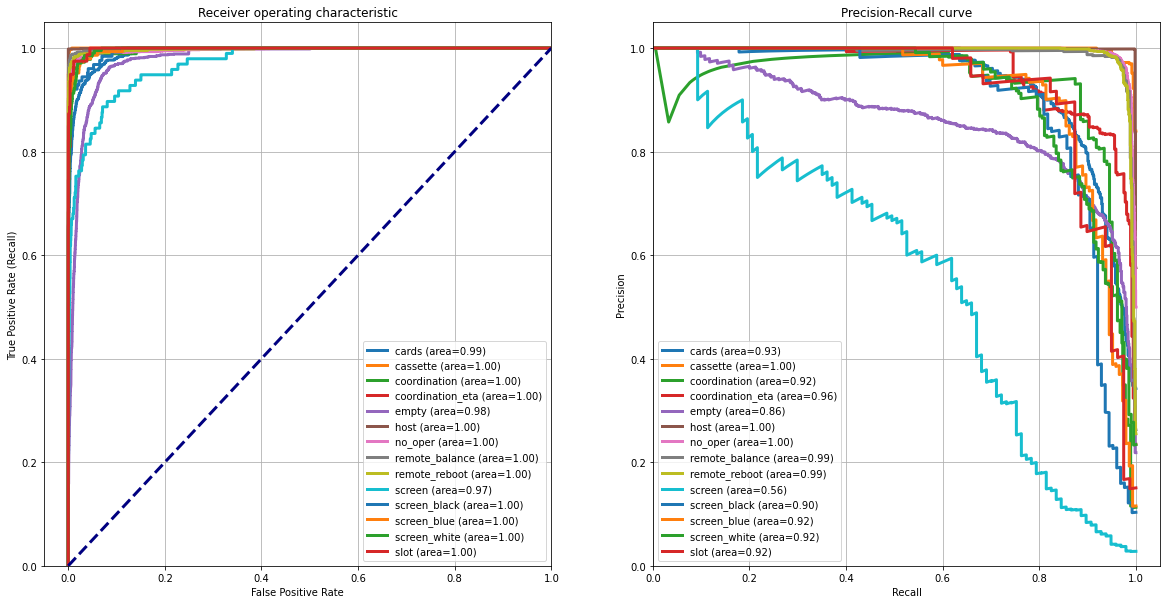

In [30]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class='ovr')
print('Accuracy:',  round(accuracy,2))
print('Auc:', round(auc,2))
print('Detail:')
print(metrics.classification_report(y_test, predicted))
    
## Построим матрицу ошибок
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel='Pred', ylabel='True', xticklabels=classes, 
       yticklabels=classes, title='Confusion matrix')
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
## Построим roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel='True Positive Rate (Recall)', 
          title='Receiver operating characteristic')
ax[0].legend(loc='lower right')
ax[0].grid(True)
    
## Построим precision-recall
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel='Precision', title='Precision-Recall curve')
ax[1].legend(loc='best')
ax[1].grid(True)
plt.show()

In [31]:
## Пример наблюдения
i = 0
txt_instance = dtf_test['text'].iloc[i]
## Проверим истинное и прогнозируемое значение
print('True:', y_test[i], '--> Pred:', predicted[i], '| Prob:', round(np.max(predicted_prob[i]),2))
## Объяснение:
explainer = lime_text.LimeTextExplainer(class_names=
             np.unique(y_train))
explained = explainer.explain_instance(txt_instance, 
             model.predict_proba, num_features=5)
explained.show_in_notebook(text=txt_instance, predict_proba=False)

True: cards --> Pred: cards | Prob: 0.57


## Результаты:
Модель BoW показала 0.91 accuracy, но с трудом распознавала метки screen и slot. 

С помощью примера из библиотеки lime видим, как алгоритм классифицирует тексты

# Использование ruBERT от deeppavlov <a class="anchor" id="rubert"></a>

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

Используем уже натренированную модель от DeepPavlov

In [33]:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, 
                                                    ppb.BertTokenizer, 'DeepPavlov/rubert-base-cased-conversational')

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [34]:
dtf['category_id'] = dtf['y'].factorize()[0]

In [35]:
dtf.head()

,y,text,text_clean,category_id
0,cards,со слов клиента- банкомат не однократно осущес...,слов клиента банкомат однократно осуществляет ...,0
2,no_oper,нет операций,нет операций,1
3,remote_reboot,просьба перезагрузить банкомат по питанию удал...,просьба перезагрузить банкомат питанию удаленн...,2
4,cards,проблемы с картридером - захват карт - не возв...,проблемы картридером захват карт возвращает жа...,0
5,no_oper,отсутствуют операции,отсутствуют операции,1


In [36]:
dtf_train, dtf_test = model_selection.train_test_split(dtf, test_size=0.3)
## get target
y_train = dtf_train['category_id'].values
y_test = dtf_test['category_id'].values

In [37]:
dtf_train.shape

(23411, 4)

In [38]:
dtf_test.shape

(10034, 4)

Процесс расчета эмбеддингов достаточно долгий, поэтому будем использовать случайную подвыборку для демонстрации возможностей

In [39]:
train_mask = np.random.choice(dtf.index, 2048*2, replace = False)
test_mask = np.random.choice(dtf.drop(train_mask).index, 2048, replace = False)

Применяем токенайзер, идущий вместе с моделью, для получения закодиронной последовательности токенов из текстов

In [40]:
tokenized1 = dtf.loc[train_mask, 'text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [41]:
tokenized2 = dtf.loc[test_mask, 'text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

Дополняем остальную часть последотельности 0-ми, чтобы все тензоры были равной размерности.

In [42]:
max_len = 0
for i in tokenized1.values:
    if len(i) > max_len:
        max_len = len(i)

padded1 = np.array([i + [0]*(max_len-len(i)) for i in tokenized1.values])
padded2 = np.array([i + [0]*(max_len-len(i)) if len(i)<max_len  else i[:max_len] for i in tokenized2.values ])

In [43]:
padded1.shape

(4096, 129)

In [44]:
padded2.shape

(2048, 129)

В данном случае видно, что конец предложения заполнен нулями для того, чтобы фокусироваться на начале предложения, тк часто в начале предложения кроется основной смысл текста

In [45]:
def get_embeddings(padded):
  # Добавляем "внимание" модели на тех токенах, которые не 0,
  # чтобы модель не путалась в переданных последовательностях

  attention_mask = np.where(padded != 0, 1, 0)
  
  
  input_ids = torch.tensor(padded)  
  attention_mask = torch.tensor(attention_mask)

  with torch.no_grad():
      last_hidden_states = model(input_ids, attention_mask=attention_mask)

  # Давайте нарежем только ту часть тензора, которая нам нужна. Это результат, 
  # соответствующий первому токену каждого предложения. Способ, которым BERT 
  # выполняет классификацию предложений, заключается в том, что он добавляет 
  # токен, называемый [CLS] (для классификации), в начало каждого предложения. 
  # Выход, соответствующий этому токену, можно рассматривать как эмбеддинг 
  # для всего предложения.

  features = last_hidden_states[0][:,0,:].numpy()
  return features


Получаем эмбеддинги для тренировочной выборки и для тестовой выборки

In [46]:
train_emb = get_embeddings(padded1)

In [47]:
test_emb = get_embeddings(padded2)

In [48]:
train_emb.shape

(4096, 768)

In [49]:
test_emb.shape

(2048, 768)

# Построение логистической регрессии на эмбеддингах ruBERT <a class="anchor" id="log"></a>

In [50]:
lr_clf = LogisticRegression()
lr_clf.fit(train_emb, list(dtf.loc[train_mask, 'category_id'].values))

LogisticRegression()

In [51]:
y_pred = lr_clf.predict_proba(test_emb)

In [52]:
from sklearn.metrics import roc_auc_score, classification_report

In [53]:
roc_auc_score(list(dtf.loc[test_mask, 'category_id'].values), y_pred, multi_class = 'ovr')

0.9870460543004809

Точность roc_auc составила 98%

In [54]:
print(classification_report(list(dtf.loc[test_mask, 'category_id'].values), 
                            np.round(y_pred[:, 1], 0)))

              precision    recall  f1-score   support

           0       0.10      1.00      0.19       143
           1       0.99      0.96      0.98       684
           2       0.00      0.00      0.00       271
           3       0.00      0.00      0.00       236
           4       0.00      0.00      0.00       101
           5       0.00      0.00      0.00       276
           6       0.00      0.00      0.00        33
           7       0.00      0.00      0.00        30
           8       0.00      0.00      0.00        37
           9       0.00      0.00      0.00        20
          10       0.00      0.00      0.00        71
          11       0.00      0.00      0.00        22
          12       0.00      0.00      0.00        78
          13       0.00      0.00      0.00        46

    accuracy                           0.39      2048
   macro avg       0.08      0.14      0.08      2048
weighted avg       0.34      0.39      0.34      2048



Т.к. изначальное распределение было неравномерное (около 12000 no_oper меток и остальные были распределены неравномерно), то как раз таки ruBERT посчитал, что половину из них посчитал с точностью 0.98, в то время как на остальных 12ти метках посчитал с точносью 0.1.
И как раз таки overall accuracy получился 0.39

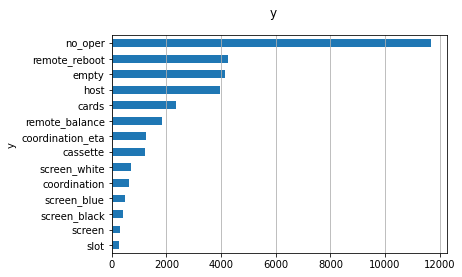

In [55]:
fig, ax = plt.subplots()
fig.suptitle('y', fontsize=12)
dtf['y'].reset_index().groupby('y').count().sort_values(by= 
       'index').plot(kind='barh', legend=False, 
        ax=ax).grid(axis='x')
plt.show()